# Basic Imports

In [1]:
import self_distillation
import saving_loading
import generate
import wandb
import util
import os

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb
os.environ['WANDB_NOTEBOOK_NAME'] = "Cin_256_custom.ipynb"

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

# config_path=f"{cwd}/models/configs/celebahq-ldm-vq-4.yaml"
# model_path=f"{cwd}/models/CelebA.ckpt"

teacher, sampler_teacher = util.create_models(config_path, model_path, student=False)
original, sampler_original = util.create_models(config_path, model_path, student=False)

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


# Teacher-Student Distillation

In [ ]:
ddim_steps = [64]
run_name = "unconditional"
generations = 100000
lr=0.00000001
config = f"{cwd}/models/configs/cin256-v2-custom.yaml"
original_model_path = f"{cwd}/models/cin256_original.ckpt"
distill(ddim_steps, generations, run_name, config, original_model_path, lr=lr, start_trained=False)

## Create teacher and student model

Only the student or teacher:

(setting student=False will only return a single model)

In [2]:
teacher, sampler_teacher = util.create_models(config_path, model_path, student=False)
# student, sampler_student = create_models(config_path, model_path, student=False)

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


# Teacher-Student Distillation

# Comparing trained student with Teacher


In [ ]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb
os.environ['WANDB_NOTEBOOK_NAME'] = "Cin_256_custom.ipynb"

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"
teacher, sampler_teacher = util.create_models(config_path, model_path, student=False)
path = "C:\Diffusion_Thesis\cin_256\data\success\\1-8_25000\\4\\student_lr8_scheduled.pt"
student, sampler_student, optimizer, scheduler = util.load_trained(path, config_path)


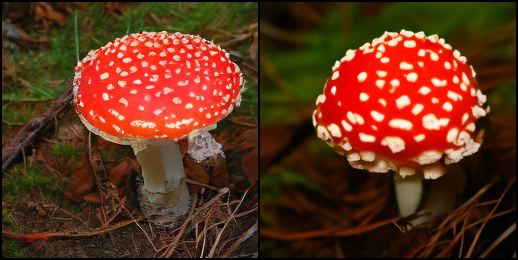

In [3]:

images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[16], prompt=992)
images

# Self-Distillation

In [2]:
step_scheduler = "iterative"
model_NAME = "CIN256"

wandb: Currently logged in as: pmobiluss. Use `wandb login --relogin` to force relogin


100%|██████████| 31/31 [05:00<00:00,  9.70s/it, epoch_loss=0.00139]


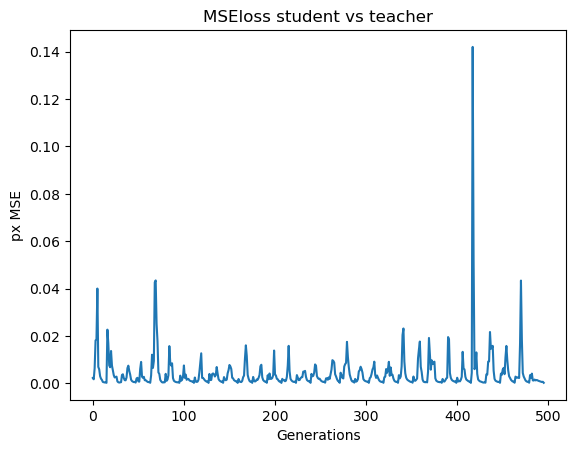

In [3]:
steps = 64
generations = 1000
model_generations = generations // steps
lr = 0.00000001 
decrease_steps = True
optimizer, scheduler = util.get_optimizer(sampler_teacher, iterations=generations, lr=lr)



run_name = f"{model_NAME}-DSDI-{steps}-{lr}-{generations}"




notes = f"""Self-distilling the {steps} step original teacher into a smaller continuous model,"""
wandb_session = util.wandb_log(name=run_name, lr=lr, model=teacher, tags=["DSD Iterative", run_name, model_NAME], notes=notes)
wandb.run.log_code(".")
session = wandb_session
# session=None


self_distillation.self_distillation_CIN(teacher, sampler_teacher, original, sampler_original, optimizer, scheduler, session=session, 
                      steps=steps, generations=model_generations, early_stop=False, 
                      run_name=run_name, decrease_steps=decrease_steps, step_scheduler=step_scheduler)


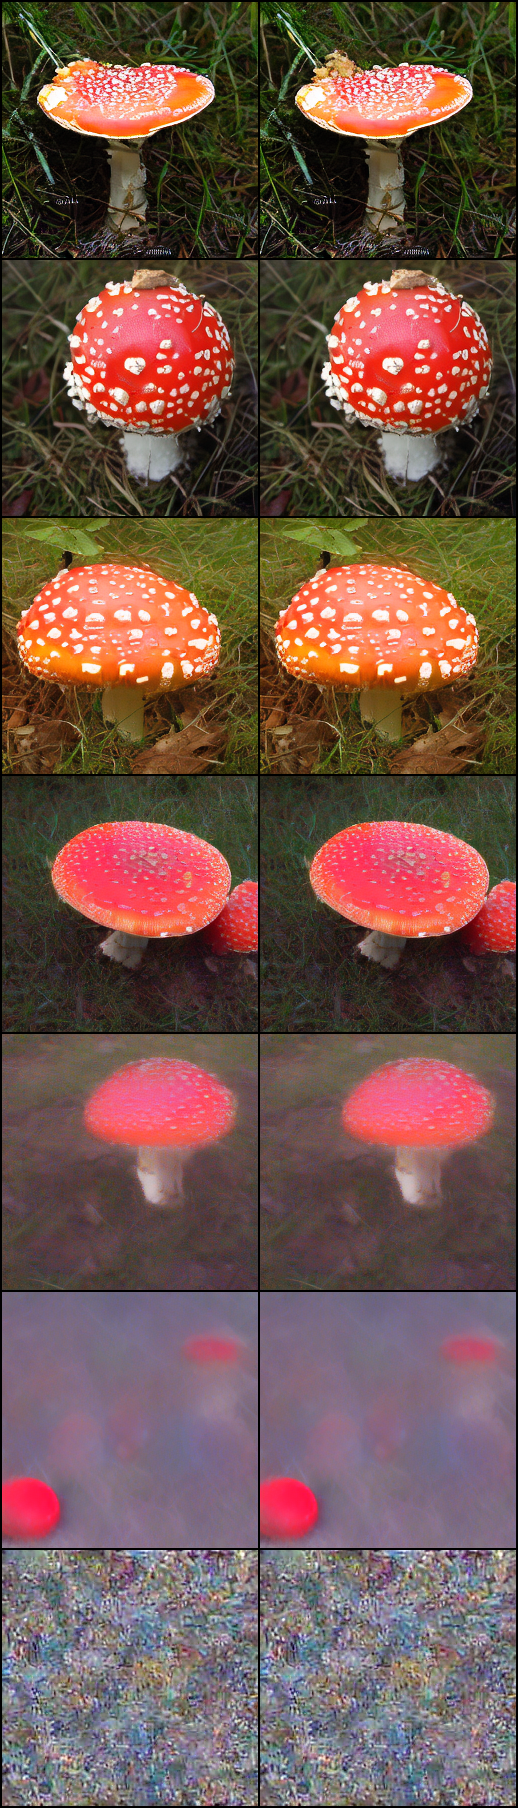

In [4]:
images, _ = util.compare_teacher_student(original, sampler_original, teacher, sampler_teacher, steps=[64, 32, 16, 8,  4, 2, 1], prompt=992)
# images, _ = util.compare_teacher_student_celeb(original, sampler_original, teacher, sampler_teacher, steps=[64, 32, 16, 8,  4, 2, 1])
images

# FID Calculations

In [ ]:
util.save_images(teacher, sampler_teacher, 50000, "original", [64, 32, 16, 8, 4, 2, 1])

In [ ]:
util.get_fid(teacher, sampler_teacher, num_imgs=100, name="test", instance = 1, steps=[32, 16, 4])

## Comparing FID

In [ ]:
from pytorch_fid import fid_score
fid_score.calculate_fid_given_paths(["C:/val_saved/real_fid_both.npz", "C:/Diffusion_Thesis/cin_256/saved_images/original/64"],batch_size=64,device="cuda", dims=2048 )

# Helpful Functions

## Generating WITHOUT intermediates saved

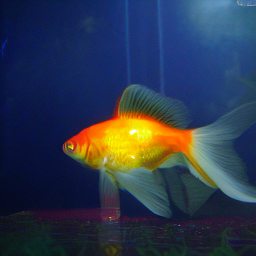

In [ ]:
img, x_T_copy, class_prompt, intermediates  = generate(teacher, sampler_teacher, steps=32, scale=3, keep_intermediates=False)
img

## Generating WITH intermediates saved

In [ ]:
intermediates, starting_noise, class_prompt = return_intermediates_for_student(teacher, sampler_teacher, steps=250)

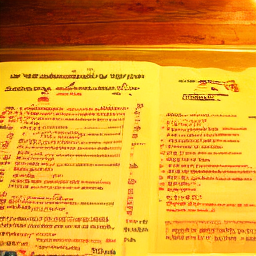

In [ ]:
latent_to_img(teacher, intermediates[125])

## Creating a dataset

In [ ]:
dataset_path = f"{cwd}/data/pre_generated/teacher_128/"
dataset_name = "teacher_128.pt"
make_dataset(teacher, sampler_teacher, 501, 128, dataset_path, dataset_name)

100%|██████████| 500/500 [1:26:03<00:00, 10.33s/it]


## Train student from pre-generated teacher dataset

In [ ]:
data_dir = f"{cwd}/data/pre_generated/teacher_128/"
datasets = os.listdir(data_dir)

In [ ]:
notes = """This is a serious attempt to distill the 128 step original teacher into a 64 step student, trained on 32000 instances"""
wandb_session = wandb_log(name="Train_student_on_128_pretrained", lr=0.00000001, model=student, tags=["distillation"], notes=notes)

optimizer, scheduler = get_optimizer(sampler_student, iterations=64*500)

dataset = torch.load(data_dir + datasets[0])
train_student_from_dataset(student, sampler_student, dataset, 64, optimizer, scheduler, early_stop=True, session=wandb_session)

wandb.finish()

save_model(sampler_student, optimizer, scheduler, name="lr8_scheduled", steps=64)

## Save and Loading trained models

In [ ]:
save_model(sampler_student, optimizer, scheduler, name="lr8_scheduled", steps=64)

In [ ]:
path = f"{cwd}/data/trained_models/64/student_lr8_scheduled.pt"
student, sampler_student, optimizer, scheduler = util.load_trained(path, config_path)

## Direct Comparison

In [ ]:
images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 8, 16, 32, 64, 128])
images

